# Neural Image Caption Generator
##### This is a Deep Learning model build using tensorflow and Keras, for genarating Captions for Images in English

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

In [10]:
# json_acceptable_string

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [11]:
type(content)

dict

In [12]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 437466


In [13]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 8441


In [14]:
freq_cnt

{'a': 62995,
 'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fing

In [15]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [16]:
threshold = 5

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 2644


In [17]:
total_words[:11]

['a', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two']

#### Prepare train and test data

In [18]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/trainImages.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/testImages.txt", 'r') as file:
    test_file_data = file.read()

In [19]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [20]:
train_data[:7]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079']

In [21]:
test_data[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [22]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [23]:
train_content['1007320043_627395c3d8']

['startseq a child playing on a rope net  endseq',
 'startseq a little girl climbing on red roping  endseq',
 'startseq a little girl in pink climbs a rope bridge at the park  endseq',
 'startseq a small child grips onto the red ropes at the playground  endseq',
 'startseq the small child climbs on a red ropes on a playground  endseq']

### Transfer Learning

#### Extract features from Image using a ResNet50 Architecture

In [24]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights = 'imagenet', input_shape = (224, 224, 3))

In [25]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [26]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [27]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

def preprocess_image (img):
    img = load_img(img, target_size=(224, 224))
    img = img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to ResNet50 requirement
    img = preprocess_input(img)

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)
Normalized image accoring to ResNet50 requirement


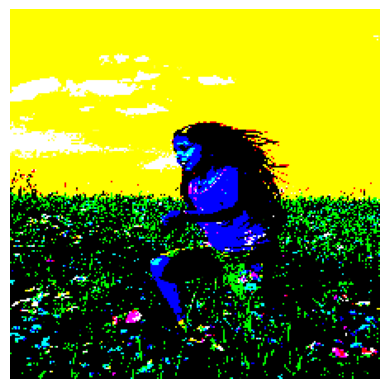

In [28]:
import matplotlib.pyplot as plt

img = preprocess_image("data/Images/174466741_329a52b2fe.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
print("Normalized image accoring to ResNet50 requirement")
plt.show()

In [29]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [ ]:
train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

for index, imageID in enumerate (train_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress...   STEP --> ", index)

In [30]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

NameError: name 'train_encoding' is not defined

In [ ]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

In [ ]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

#### Pre-process the Captions

In [ ]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [ ]:
print(len(index_to_word))

In [ ]:
print(index_to_word[5])
print(word_to_index['is'])

In [ ]:
# Add startseq and endseq also to the mappings
index_to_word[2645] = 'startseq'
word_to_index['startseq'] = 2645

index_to_word[2646] = 'endseq'
word_to_index['endseq'] = 2646

VOCAB_SIZE = len(word_to_index) + 1

In [ ]:
print(VOCAB_SIZE)

In [ ]:
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [ ]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [ ]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [ ]:
print(max_len)

In [ ]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("glove.6B.50d.txt",encoding='utf8')

In [1]:
# Create a mapping from word to embedding
word_to_embedding = {}

for line in file:
    values = line.split()

    word = values[0]
    embedding = np.array (values[1:], dtype='float')
    word_to_embedding[word] = embedding

file.close()

NameError: name 'file' is not defined

In [ ]:
word_to_embedding["apple"]

In [ ]:
EMBEDDING_DIM = 50

def get_embedding_matrix():
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, index in word_to_index.items():
        embedding = word_to_embedding.get(word)

        if embedding is not None:
            embedding_matrix[index] = embedding

    return embedding_matrix

In [ ]:
index_to_embedding = get_embedding_matrix()
print(index_to_embedding.shape)

### Define Model Architecture
##### Build a Neural Network using Keras Functional API

In [ ]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of ResNet goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 essentially captures the entire sentence that has been generated till now

In [ ]:
from tensorflow.keras.layers import add

# Decode the inputs

# So effectively, an image (224x224x3) goes through ResNet50
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[inp_img_features, inp_cap], outputs=outputs)

In [ ]:
model.summary()

In [ ]:
# Preinitialise Embedding layer
model.layers[2].set_weights([index_to_embedding])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

#### Create a Data Loader

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0     

### Train Model

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_content)//batch_size 

In [ ]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

In [ ]:
keras.utils.plot_model(model, "Model.png", show_shapes=True)

# Refrences: 

    Main: https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/
    
    CNN: https://www.analyticsvidhya.com/blog/2021/07/convolution-neural-network-better-understanding/
    LSTM: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/
    Residual Networks (Computer Vision): https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
    Deep Learning with Python by Fraçois Chollet

## Keras
    https://keras.io/guides/serialization_and_saving/
    https://keras.io/guides/functional_api/

## Deep Residual Learning for Image Recognition
    https://www.ijcai.org/Proceedings/15/Papers/593.pdf
    https://arxiv.org/abs/1411.4555v2
    https://arxiv.org/abs/1512.03385
    
    https://jair.org/index.php/jair/article/view/10833
